In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_33498/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


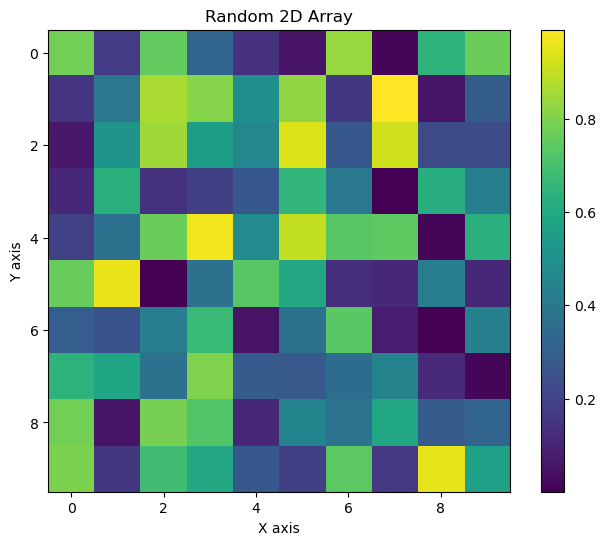

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
 # dvs 데이터 시각화 코드
 ##############################################################################################
            # mapping = {
            #     0: 'Hand Clapping',
            #     1: 'Right Hand Wave',
            #     2: 'Left Hand Wave',
            #     3: 'Right Arm CW',
            #     4: 'Right Arm CCW',
            #     5: 'Left Arm CW',
            #     6: 'Left Arm CCW',
            #     7: 'Arm Roll',
            #     8: 'Air Drums',
            #     9: 'Air Guitar',
            #     10: 'Other'
            # }
def dvs_visualization(inputs, labels, TIME, BATCH):
            
    what_input = random.randint(0, BATCH - 1)
    inputs_for_view = inputs.permute(1, 0, 2, 3, 4)
    for i in range(TIME):
        # 예시 데이터 생성
        data1 = inputs_for_view[what_input][i][0].numpy()  # torch tensor를 numpy 배열로 변환
        data2 = inputs_for_view[what_input][i][1].numpy()  # torch tensor를 numpy 배열로 변환

        # 데이터 플로팅
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열의 subplot 생성

        # 첫 번째 subplot에 데이터1 플로팅
        im1 = axs[0].imshow(data1, cmap='viridis', interpolation='nearest')
        axs[0].set_title(f'Channel 0\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[0].set_xlabel('X axis')
        axs[0].set_ylabel('Y axis')
        axs[0].grid(False)
        fig.colorbar(im1, ax=axs[0])  # Color bar 추가

        # 두 번째 subplot에 데이터2 플로팅
        im2 = axs[1].imshow(data2, cmap='viridis', interpolation='nearest')
        axs[1].set_title(f'Channel 1\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[1].set_xlabel('X axis')
        axs[1].set_ylabel('Y axis')
        axs[1].grid(False)
        fig.colorbar(im2, ax=axs[1])  # Color bar 추가

        plt.tight_layout()  # subplot 간 간격 조정
        plt.show()
    sys.exit("종료")

######################################################################################################

In [5]:
def my_snn_system(devices = "0,1,2,3",
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.init(project= f'my_snn {unique_name}')
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_{learning_rate}_{unique_name}_{which_data}_{TIME}'
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                print('past_in_channel', past_in_channel)
                print('bias_param', bias_param)
                print('in_channel', in_channel)
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        if (convTrue_fcFalse == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                     synapse_fc_trace_const1, synapse_fc_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on).to(device)
        else:
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                     synapse_conv_kernel_size, synapse_conv_stride, 
                     synapse_conv_padding, synapse_conv_trace_const1, 
                     synapse_conv_trace_const2, 
                     lif_layer_v_init, lif_layer_v_decay, 
                     lif_layer_v_threshold, lif_layer_v_reset,
                     lif_layer_sg_width,
                     synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                     tdBN_on,
                     BN_on, TIME,
                     surrogate,
                     BPTT_on,
                     OTTT_sWS_on).to(device)
        
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()
        running_loss = 0.0

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            # print('inputs',inputs.size(),'\nlabels',labels.size())
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
                
            # # DVS에서 time duration으로 잘랐을 때는 timestep 맞춰주자 --> data 가져올 때, 그 함수 안에서 처리함.
            # if (dvs_duration > 0): 
            #     # inputs.size(1)를 TIME으로 맞추기
            #     T, *spatial_dims = inputs.shape
            #     if T > TIME:
            #         inputs = inputs[:TIME]
            #     else:
            #         inputs = torch.cat([inputs, torch.zeros(TIME - T, *spatial_dims)], dim=0)
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################


            ## device로 보내주기 ######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################


            # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
            # inputs: [Time, Batch, Channel, Height, Width]   
            inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
            # inputs: [Batch, Time, Channel, Height, Width] 
            #################################################################################################


            ### input --> net --> output #####################################################
            outputs = net(inputs)
            ##################################################################################

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            batch = BATCH 
            if labels.size(0) != BATCH: 
                batch = labels.size(0)
            #######################################################################
            


            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted[0:batch] == labels).sum().item()
            tr_total += total
            tr_correct += correct
            iter_acc = correct / total
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            

            ## loss, backward ##########################################
            loss = criterion(outputs[0:batch,:], labels)
            loss.backward()
            ############################################################

            ### gradinet verbose ##########################################
            if (gradient_verbose == True):
                if (i % verbose_interval == verbose_interval-1):
                    print('\n\nepoch', epoch, 'iter', i)
                    for name, param in net.named_parameters():
                        if param.requires_grad:
                            print('\n\n\n\n' , name, param.grad)
            ################################################################
            

            ## weight 업데이트!! ##################################
            optimizer.step()
            ################################################################


            running_loss += loss.item()
            # print("Epoch: {}, Iter: {}, Loss: {}".format(epoch + 1, i + 1, running_loss / 100))

            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = net(inputs.permute(1, 0, 2, 3, 4))
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        batch = BATCH 
                        if labels.size(0) != BATCH: 
                            batch = labels.size(0)
                        correct += (predicted[0:batch] == labels).sum().item()
                        val_loss = criterion(outputs[0:batch,:], labels)

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            # # 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기)
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)

            np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                json.dump(hyperparameters, f, indent=4)
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [6]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

my_snn_system(  devices = "5",
                unique_name = unique_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace()
      (1): LIF_layer_trace()
      (2): Scale()
      (3): SYNAPSE_CONV_trace()
      (4): LIF_layer_trace()
      (5): Scale()
      (6): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (7): SYNAPSE_CONV_trace()
      (8): LIF_layer_trace()
      (9): Scale()
      (10): SYNAPSE_CONV_trace()
      (11): LIF_layer_trace()
      (12): Scale()
      (13): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (14): SYNAPSE_CONV_trace()
      (15): LIF_layer_trace()
      (16): Scale()
      (17): SYNAPSE_CONV_trace()
      (18): LIF_layer_trace()
      (19): Scale()
      (20): DimChanger_for_pooling(
        (ann_module): AvgPool2d(kernel_size=2, stride=2, padding=0)
      )
      (21): SYNAPSE_CONV_trace(

iter_acc: 0-390/391 iter_acc: 28.75%, lr=['1'], iter_loss: 0.31921157240867615, val_acc: 31.65%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.3713972568512 seconds

EPOCH 1



iter_acc: 1-390/391 iter_acc: 47.50%, lr=['0.9999725846827561'], iter_loss: 0.2480088770389557, val_acc: 51.69%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.7286241054535 seconds

EPOCH 2



iter_acc: 2-390/391 iter_acc: 48.75%, lr=['0.9998903417374227'], iter_loss: 0.22062236070632935, val_acc: 59.19%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.96271800994873 seconds

EPOCH 3



iter_acc: 3-390/391 iter_acc: 57.50%, lr=['0.9997532801828658'], iter_loss: 0.20385131239891052, val_acc: 62.44%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.53349351882935 seconds

EPOCH 4



iter_acc: 4-390/391 iter_acc: 71.25%, lr=['0.9995614150494292'], iter_loss: 0.1644383668899536, val_acc: 67.81%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s] 

epoch_time: 193.6839725971222 seconds

EPOCH 5



iter_acc: 5-390/391 iter_acc: 71.25%, lr=['0.9993147673772869'], iter_loss: 0.15970803797245026, val_acc: 70.89%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]

epoch_time: 196.08370733261108 seconds

EPOCH 6



iter_acc: 6-390/391 iter_acc: 75.00%, lr=['0.9990133642141358'], iter_loss: 0.13233554363250732, val_acc: 71.19%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.36187958717346 seconds

EPOCH 7



iter_acc: 7-390/391 iter_acc: 76.25%, lr=['0.998657238612229'], iter_loss: 0.1418655514717102, val_acc: 75.10%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s] 

epoch_time: 193.53032684326172 seconds

EPOCH 8



iter_acc: 8-390/391 iter_acc: 70.00%, lr=['0.9982464296247522'], iter_loss: 0.13492269814014435, val_acc: 76.45%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.99269199371338 seconds

EPOCH 9



iter_acc: 9-390/391 iter_acc: 75.00%, lr=['0.99778098230154'], iter_loss: 0.14049386978149414, val_acc: 76.67%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.46526908874512 seconds

EPOCH 10



iter_acc: 10-390/391 iter_acc: 72.50%, lr=['0.9972609476841366'], iter_loss: 0.14282983541488647, val_acc: 79.64%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 194.03721976280212 seconds

EPOCH 11



iter_acc: 11-390/391 iter_acc: 81.25%, lr=['0.9966863828001982'], iter_loss: 0.11863183975219727, val_acc: 79.78%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.4431028366089 seconds

EPOCH 12



iter_acc: 12-390/391 iter_acc: 75.00%, lr=['0.996057350657239'], iter_loss: 0.14100535213947296, val_acc: 80.72%: 100%|██████████| 391/391 [03:12<00:00,  2.03it/s]

epoch_time: 192.94816398620605 seconds

EPOCH 13



iter_acc: 13-390/391 iter_acc: 72.50%, lr=['0.9953739202357218'], iter_loss: 0.13668227195739746, val_acc: 81.54%: 100%|██████████| 391/391 [03:13<00:00,  2.02it/s]

epoch_time: 193.73445057868958 seconds

EPOCH 14



iter_acc: 14-390/391 iter_acc: 76.25%, lr=['0.9946361664814942'], iter_loss: 0.12442152947187424, val_acc: 82.80%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.46796774864197 seconds

EPOCH 15



iter_acc: 15-390/391 iter_acc: 83.75%, lr=['0.9938441702975689'], iter_loss: 0.10125340521335602, val_acc: 83.37%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s]

epoch_time: 194.89391613006592 seconds

EPOCH 16



iter_acc: 16-390/391 iter_acc: 76.25%, lr=['0.9929980185352525'], iter_loss: 0.1264445036649704, val_acc: 83.82%: 100%|██████████| 391/391 [03:14<00:00,  2.01it/s] 

epoch_time: 195.03747463226318 seconds

EPOCH 17



iter_acc: 17-390/391 iter_acc: 86.25%, lr=['0.9920978039846209'], iter_loss: 0.09336791932582855, val_acc: 83.95%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]

epoch_time: 195.62209296226501 seconds

EPOCH 18



iter_acc: 18-390/391 iter_acc: 82.50%, lr=['0.9911436253643444'], iter_loss: 0.10963635891675949, val_acc: 84.43%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.6295554637909 seconds

EPOCH 19



iter_acc: 19-390/391 iter_acc: 82.50%, lr=['0.9901355873108609'], iter_loss: 0.10700829327106476, val_acc: 84.93%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.85963082313538 seconds

EPOCH 20



iter_acc: 20-390/391 iter_acc: 86.25%, lr=['0.9890738003669028'], iter_loss: 0.08587899059057236, val_acc: 85.65%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.241060256958 seconds

EPOCH 21



iter_acc: 21-390/391 iter_acc: 73.75%, lr=['0.9879583809693737'], iter_loss: 0.11847160756587982, val_acc: 85.34%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.3154923915863 seconds

EPOCH 22



iter_acc: 22-390/391 iter_acc: 88.75%, lr=['0.9867894514365801'], iter_loss: 0.08094638586044312, val_acc: 85.61%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]

epoch_time: 196.1181468963623 seconds

EPOCH 23



iter_acc: 23-390/391 iter_acc: 75.00%, lr=['0.985567139954818'], iter_loss: 0.12900859117507935, val_acc: 85.75%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.94121026992798 seconds

EPOCH 24



iter_acc: 24-390/391 iter_acc: 86.25%, lr=['0.9842915805643155'], iter_loss: 0.0740995705127716, val_acc: 86.55%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]  

epoch_time: 197.57109546661377 seconds

EPOCH 25



iter_acc: 25-390/391 iter_acc: 86.25%, lr=['0.9829629131445341'], iter_loss: 0.0749717578291893, val_acc: 87.15%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.30631804466248 seconds

EPOCH 26



iter_acc: 26-390/391 iter_acc: 86.25%, lr=['0.9815812833988291'], iter_loss: 0.08307316154241562, val_acc: 87.43%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s] 

epoch_time: 204.62483501434326 seconds

EPOCH 27



iter_acc: 27-390/391 iter_acc: 87.50%, lr=['0.9801468428384715'], iter_loss: 0.0836344063282013, val_acc: 87.23%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]  

epoch_time: 198.60039830207825 seconds

EPOCH 28



iter_acc: 28-390/391 iter_acc: 82.50%, lr=['0.9786597487660336'], iter_loss: 0.07826577126979828, val_acc: 87.21%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 198.18783116340637 seconds

EPOCH 29



iter_acc: 29-390/391 iter_acc: 90.00%, lr=['0.9771201642581384'], iter_loss: 0.06410585343837738, val_acc: 87.35%: 100%|██████████| 391/391 [03:16<00:00,  1.98it/s] 

epoch_time: 197.16488575935364 seconds

EPOCH 30



iter_acc: 30-390/391 iter_acc: 82.50%, lr=['0.9755282581475768'], iter_loss: 0.09050731360912323, val_acc: 86.62%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.79566192626953 seconds

EPOCH 31



iter_acc: 31-390/391 iter_acc: 88.75%, lr=['0.9738842050047929'], iter_loss: 0.06320501863956451, val_acc: 87.12%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.88569712638855 seconds

EPOCH 32



iter_acc: 32-390/391 iter_acc: 86.25%, lr=['0.9721881851187406'], iter_loss: 0.07991766929626465, val_acc: 88.02%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.75630068778992 seconds

EPOCH 33



iter_acc: 33-390/391 iter_acc: 85.00%, lr=['0.9704403844771128'], iter_loss: 0.06667156517505646, val_acc: 88.16%: 100%|██████████| 391/391 [03:15<00:00,  1.99it/s] 

epoch_time: 196.1778748035431 seconds

EPOCH 34



iter_acc: 34-390/391 iter_acc: 91.25%, lr=['0.9686409947459458'], iter_loss: 0.06303250044584274, val_acc: 88.81%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.40457105636597 seconds

EPOCH 35



iter_acc: 35-390/391 iter_acc: 90.00%, lr=['0.9667902132486008'], iter_loss: 0.0651724636554718, val_acc: 88.77%: 100%|██████████| 391/391 [03:15<00:00,  2.00it/s]  

epoch_time: 195.91855311393738 seconds

EPOCH 36



iter_acc: 36-390/391 iter_acc: 88.75%, lr=['0.9648882429441257'], iter_loss: 0.07191511988639832, val_acc: 88.56%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 197.08577394485474 seconds

EPOCH 37



iter_acc: 37-390/391 iter_acc: 91.25%, lr=['0.9629352924049974'], iter_loss: 0.05739416927099228, val_acc: 88.38%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.64264464378357 seconds

EPOCH 38



iter_acc: 38-390/391 iter_acc: 88.75%, lr=['0.9609315757942503'], iter_loss: 0.05980353802442551, val_acc: 88.75%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 197.14672994613647 seconds

EPOCH 39



iter_acc: 39-390/391 iter_acc: 97.50%, lr=['0.9588773128419905'], iter_loss: 0.04580157250165939, val_acc: 88.53%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.3621084690094 seconds

EPOCH 40



iter_acc: 40-390/391 iter_acc: 90.00%, lr=['0.9567727288213004'], iter_loss: 0.07315526902675629, val_acc: 88.95%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.33155298233032 seconds

EPOCH 41



iter_acc: 41-390/391 iter_acc: 93.75%, lr=['0.9546180545235343'], iter_loss: 0.062345098704099655, val_acc: 88.78%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 197.160658121109 seconds

EPOCH 42



iter_acc: 42-390/391 iter_acc: 88.75%, lr=['0.9524135262330098'], iter_loss: 0.06187243014574051, val_acc: 88.70%: 100%|██████████| 391/391 [03:56<00:00,  1.65it/s] 

epoch_time: 236.83705115318298 seconds

EPOCH 43



iter_acc: 43-390/391 iter_acc: 91.25%, lr=['0.9501593857010968'], iter_loss: 0.06959732621908188, val_acc: 89.07%: 100%|██████████| 391/391 [03:52<00:00,  1.68it/s] 

epoch_time: 232.4427511692047 seconds

EPOCH 44



iter_acc: 44-390/391 iter_acc: 96.25%, lr=['0.9478558801197065'], iter_loss: 0.047968119382858276, val_acc: 89.42%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.6669623851776 seconds

EPOCH 45



iter_acc: 45-390/391 iter_acc: 87.50%, lr=['0.9455032620941839'], iter_loss: 0.07376059144735336, val_acc: 89.43%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.61131858825684 seconds

EPOCH 46



iter_acc: 46-390/391 iter_acc: 92.50%, lr=['0.9431017896156073'], iter_loss: 0.05888180062174797, val_acc: 88.73%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.48612141609192 seconds

EPOCH 47



iter_acc: 47-390/391 iter_acc: 95.00%, lr=['0.940651726032496'], iter_loss: 0.0521005243062973, val_acc: 89.20%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]  

epoch_time: 197.8446249961853 seconds

EPOCH 48



iter_acc: 48-390/391 iter_acc: 91.25%, lr=['0.9381533400219317'], iter_loss: 0.06284217536449432, val_acc: 89.41%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.43972659111023 seconds

EPOCH 49



iter_acc: 49-390/391 iter_acc: 91.25%, lr=['0.9356069055600947'], iter_loss: 0.05286335572600365, val_acc: 89.64%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.81668210029602 seconds

EPOCH 50



iter_acc: 50-390/391 iter_acc: 92.50%, lr=['0.9330127018922193'], iter_loss: 0.06633717566728592, val_acc: 89.74%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.72147607803345 seconds

EPOCH 51



iter_acc: 51-390/391 iter_acc: 92.50%, lr=['0.9303710135019718'], iter_loss: 0.059038564562797546, val_acc: 88.98%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.7703197002411 seconds

EPOCH 52



iter_acc: 52-390/391 iter_acc: 96.25%, lr=['0.9276821300802534'], iter_loss: 0.041621677577495575, val_acc: 88.90%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.25307607650757 seconds

EPOCH 53



iter_acc: 53-390/391 iter_acc: 90.00%, lr=['0.924946346493432'], iter_loss: 0.05612233281135559, val_acc: 89.96%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.5627145767212 seconds

EPOCH 54



iter_acc: 54-390/391 iter_acc: 95.00%, lr=['0.9221639627510075'], iter_loss: 0.049134425818920135, val_acc: 89.73%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.90093159675598 seconds

EPOCH 55



iter_acc: 55-390/391 iter_acc: 95.00%, lr=['0.919335283972712'], iter_loss: 0.05141478031873703, val_acc: 89.29%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.2481632232666 seconds

EPOCH 56



iter_acc: 56-390/391 iter_acc: 93.75%, lr=['0.9164606203550497'], iter_loss: 0.043466344475746155, val_acc: 89.71%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.8483908176422 seconds

EPOCH 57



iter_acc: 57-390/391 iter_acc: 93.75%, lr=['0.9135402871372809'], iter_loss: 0.049566980451345444, val_acc: 89.92%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s]

epoch_time: 196.26467037200928 seconds

EPOCH 58



iter_acc: 58-390/391 iter_acc: 95.00%, lr=['0.910574604566852'], iter_loss: 0.044442713260650635, val_acc: 90.29%: 100%|██████████| 391/391 [03:16<00:00,  1.99it/s] 

epoch_time: 196.80785846710205 seconds

EPOCH 59



iter_acc: 59-390/391 iter_acc: 95.00%, lr=['0.907563897864277'], iter_loss: 0.05318521708250046, val_acc: 90.02%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.70764899253845 seconds

EPOCH 60



iter_acc: 60-390/391 iter_acc: 100.00%, lr=['0.9045084971874737'], iter_loss: 0.03268543630838394, val_acc: 90.08%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.2469506263733 seconds

EPOCH 61



iter_acc: 61-390/391 iter_acc: 95.00%, lr=['0.9014087375955573'], iter_loss: 0.045095160603523254, val_acc: 89.53%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.39912676811218 seconds

EPOCH 62



iter_acc: 62-390/391 iter_acc: 92.50%, lr=['0.8982649590120981'], iter_loss: 0.048689231276512146, val_acc: 90.09%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.3388524055481 seconds

EPOCH 63



iter_acc: 63-390/391 iter_acc: 96.25%, lr=['0.8950775061878451'], iter_loss: 0.048622891306877136, val_acc: 90.01%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]

epoch_time: 197.5875289440155 seconds

EPOCH 64



iter_acc: 64-390/391 iter_acc: 92.50%, lr=['0.8918467286629199'], iter_loss: 0.05647214874625206, val_acc: 90.24%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.36322855949402 seconds

EPOCH 65



iter_acc: 65-390/391 iter_acc: 92.50%, lr=['0.8885729807284855'], iter_loss: 0.057820141315460205, val_acc: 90.02%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]

epoch_time: 198.83354568481445 seconds

EPOCH 66



iter_acc: 66-390/391 iter_acc: 96.25%, lr=['0.8852566213878946'], iter_loss: 0.040418997406959534, val_acc: 89.85%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]

epoch_time: 199.44124054908752 seconds

EPOCH 67



iter_acc: 67-390/391 iter_acc: 100.00%, lr=['0.8818980143173212'], iter_loss: 0.0327717624604702, val_acc: 90.36%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.58755016326904 seconds

EPOCH 68



iter_acc: 68-390/391 iter_acc: 93.75%, lr=['0.8784975278258782'], iter_loss: 0.04843111336231232, val_acc: 89.79%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 200.10335612297058 seconds

EPOCH 69



iter_acc: 69-390/391 iter_acc: 96.25%, lr=['0.8750555348152298'], iter_loss: 0.03610536456108093, val_acc: 90.62%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.22629857063293 seconds

EPOCH 70



iter_acc: 70-390/391 iter_acc: 95.00%, lr=['0.8715724127386972'], iter_loss: 0.04292302578687668, val_acc: 90.33%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.4859766960144 seconds

EPOCH 71



iter_acc: 71-390/391 iter_acc: 93.75%, lr=['0.8680485435598672'], iter_loss: 0.05311071127653122, val_acc: 90.70%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 200.1179428100586 seconds

EPOCH 72



iter_acc: 72-390/391 iter_acc: 92.50%, lr=['0.8644843137107058'], iter_loss: 0.0563424751162529, val_acc: 90.29%: 100%|██████████| 391/391 [03:18<00:00,  1.96it/s]  

epoch_time: 199.16805005073547 seconds

EPOCH 73



iter_acc: 73-390/391 iter_acc: 90.00%, lr=['0.8608801140491811'], iter_loss: 0.052509114146232605, val_acc: 91.03%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]

epoch_time: 200.80809020996094 seconds

EPOCH 74



iter_acc: 74-390/391 iter_acc: 96.25%, lr=['0.8572363398164017'], iter_loss: 0.03913494199514389, val_acc: 90.24%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.94736576080322 seconds

EPOCH 75



iter_acc: 75-390/391 iter_acc: 91.25%, lr=['0.8535533905932737'], iter_loss: 0.05006583780050278, val_acc: 90.04%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.75671863555908 seconds

EPOCH 76



iter_acc: 76-390/391 iter_acc: 98.75%, lr=['0.8498316702566828'], iter_loss: 0.04008130729198456, val_acc: 91.02%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s] 

epoch_time: 198.93174743652344 seconds

EPOCH 77



iter_acc: 77-390/391 iter_acc: 92.50%, lr=['0.8460715869352033'], iter_loss: 0.04395381733775139, val_acc: 90.28%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 197.99351239204407 seconds

EPOCH 78



iter_acc: 78-390/391 iter_acc: 95.00%, lr=['0.8422735529643444'], iter_loss: 0.04884784668684006, val_acc: 90.67%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s]  

epoch_time: 197.40542721748352 seconds

EPOCH 79



iter_acc: 79-390/391 iter_acc: 93.75%, lr=['0.8384379848413304'], iter_loss: 0.05477028340101242, val_acc: 90.43%: 100%|██████████| 391/391 [03:17<00:00,  1.98it/s] 

epoch_time: 198.05537343025208 seconds

EPOCH 80



iter_acc: 80-390/391 iter_acc: 93.75%, lr=['0.8345653031794291'], iter_loss: 0.05543141067028046, val_acc: 90.55%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.25002431869507 seconds

EPOCH 81



iter_acc: 81-390/391 iter_acc: 96.25%, lr=['0.8306559326618259'], iter_loss: 0.038865379989147186, val_acc: 90.93%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 202.09106159210205 seconds

EPOCH 82



iter_acc: 82-390/391 iter_acc: 97.50%, lr=['0.8267103019950528'], iter_loss: 0.03712853044271469, val_acc: 90.51%: 100%|██████████| 391/391 [03:18<00:00,  1.97it/s]  

epoch_time: 199.06709122657776 seconds

EPOCH 83



iter_acc: 83-390/391 iter_acc: 93.75%, lr=['0.8227288438619753'], iter_loss: 0.044524453580379486, val_acc: 90.98%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]

epoch_time: 200.31970930099487 seconds

EPOCH 84



iter_acc: 84-390/391 iter_acc: 93.75%, lr=['0.8187119948743449'], iter_loss: 0.049981579184532166, val_acc: 90.38%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]

epoch_time: 202.4458203315735 seconds

EPOCH 85



iter_acc: 85-390/391 iter_acc: 97.50%, lr=['0.8146601955249188'], iter_loss: 0.03643554449081421, val_acc: 90.66%: 100%|██████████| 391/391 [03:24<00:00,  1.92it/s]  

epoch_time: 204.27704405784607 seconds

EPOCH 86



iter_acc: 86-390/391 iter_acc: 95.00%, lr=['0.8105738901391553'], iter_loss: 0.04446031153202057, val_acc: 90.33%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.8268940448761 seconds

EPOCH 87



iter_acc: 87-390/391 iter_acc: 95.00%, lr=['0.8064535268264883'], iter_loss: 0.040539778769016266, val_acc: 90.52%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.66901803016663 seconds

EPOCH 88



iter_acc: 88-390/391 iter_acc: 95.00%, lr=['0.8022995574311875'], iter_loss: 0.040491022169589996, val_acc: 90.75%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]

epoch_time: 202.53083562850952 seconds

EPOCH 89



iter_acc: 89-390/391 iter_acc: 98.75%, lr=['0.7981124374828079'], iter_loss: 0.03058016300201416, val_acc: 90.59%: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s]  

epoch_time: 207.65798234939575 seconds

EPOCH 90



iter_acc: 90-390/391 iter_acc: 98.75%, lr=['0.7938926261462366'], iter_loss: 0.034178294241428375, val_acc: 90.27%: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s] 

epoch_time: 207.70989632606506 seconds

EPOCH 91



iter_acc: 91-390/391 iter_acc: 97.50%, lr=['0.7896405861713394'], iter_loss: 0.03129671514034271, val_acc: 90.68%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s] 

epoch_time: 209.51480531692505 seconds

EPOCH 92



iter_acc: 92-390/391 iter_acc: 91.25%, lr=['0.785356783842216'], iter_loss: 0.046209804713726044, val_acc: 90.76%: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]

epoch_time: 205.79770970344543 seconds

EPOCH 93



iter_acc: 93-390/391 iter_acc: 92.50%, lr=['0.7810416889260654'], iter_loss: 0.04943113029003143, val_acc: 90.51%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]  

epoch_time: 210.34302735328674 seconds

EPOCH 94



iter_acc: 94-390/391 iter_acc: 95.00%, lr=['0.776695774621672'], iter_loss: 0.048469360917806625, val_acc: 90.57%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]

epoch_time: 209.7847933769226 seconds

EPOCH 95



iter_acc: 95-390/391 iter_acc: 92.50%, lr=['0.7723195175075135'], iter_loss: 0.049800507724285126, val_acc: 90.99%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]

epoch_time: 201.5752317905426 seconds

EPOCH 96



iter_acc: 96-390/391 iter_acc: 93.75%, lr=['0.7679133974894983'], iter_loss: 0.041414327919483185, val_acc: 90.66%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.9315938949585 seconds

EPOCH 97



iter_acc: 97-390/391 iter_acc: 98.75%, lr=['0.7634778977483389'], iter_loss: 0.03446859121322632, val_acc: 91.29%: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]  

epoch_time: 206.09074211120605 seconds

EPOCH 98



iter_acc: 98-390/391 iter_acc: 95.00%, lr=['0.7590135046865651'], iter_loss: 0.04128221422433853, val_acc: 90.62%: 100%|██████████| 391/391 [03:21<00:00,  1.95it/s]  

epoch_time: 201.20221519470215 seconds

EPOCH 99



iter_acc: 99-390/391 iter_acc: 95.00%, lr=['0.7545207078751857'], iter_loss: 0.03929080069065094, val_acc: 90.58%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.64578342437744 seconds

EPOCH 100



iter_acc: 100-390/391 iter_acc: 95.00%, lr=['0.75'], iter_loss: 0.04125954955816269, val_acc: 90.84%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  

epoch_time: 204.3964762687683 seconds

EPOCH 101



iter_acc: 101-390/391 iter_acc: 97.50%, lr=['0.7454518768075704'], iter_loss: 0.03841619938611984, val_acc: 90.92%: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]  

epoch_time: 206.04219484329224 seconds

EPOCH 102



iter_acc: 102-390/391 iter_acc: 97.50%, lr=['0.7408768370508576'], iter_loss: 0.03634686395525932, val_acc: 90.74%: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]  

epoch_time: 205.56221389770508 seconds

EPOCH 103



iter_acc: 103-390/391 iter_acc: 98.75%, lr=['0.7362753824345271'], iter_loss: 0.027203217148780823, val_acc: 90.92%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]

epoch_time: 201.9193558692932 seconds

EPOCH 104



iter_acc: 104-390/391 iter_acc: 98.75%, lr=['0.7316480175599309'], iter_loss: 0.02943858876824379, val_acc: 90.81%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 201.29688048362732 seconds

EPOCH 105



iter_acc: 105-390/391 iter_acc: 93.75%, lr=['0.7269952498697734'], iter_loss: 0.04772142693400383, val_acc: 90.90%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 201.60816049575806 seconds

EPOCH 106



iter_acc: 106-390/391 iter_acc: 91.25%, lr=['0.7223175895924637'], iter_loss: 0.04728422686457634, val_acc: 91.21%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s]  

epoch_time: 203.00299763679504 seconds

EPOCH 107



iter_acc: 107-390/391 iter_acc: 92.50%, lr=['0.7176155496861638'], iter_loss: 0.04809855669736862, val_acc: 90.80%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s]  

epoch_time: 203.88327193260193 seconds

EPOCH 108



iter_acc: 108-390/391 iter_acc: 100.00%, lr=['0.7128896457825363'], iter_loss: 0.026395685970783234, val_acc: 90.94%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]

epoch_time: 201.83907508850098 seconds

EPOCH 109



iter_acc: 109-390/391 iter_acc: 97.50%, lr=['0.7081403961302006'], iter_loss: 0.03246387466788292, val_acc: 91.13%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  


epoch_time: 204.50299382209778 seconds

EPOCH 110


iter_acc: 110-390/391 iter_acc: 93.75%, lr=['0.7033683215379001'], iter_loss: 0.049243584275245667, val_acc: 91.27%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 211.9794979095459 seconds

EPOCH 111



iter_acc: 111-390/391 iter_acc: 100.00%, lr=['0.6985739453173903'], iter_loss: 0.027996569871902466, val_acc: 91.21%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]

epoch_time: 206.6017165184021 seconds

EPOCH 112



iter_acc: 112-390/391 iter_acc: 100.00%, lr=['0.6937577932260515'], iter_loss: 0.02910519763827324, val_acc: 91.40%: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s] 

epoch_time: 207.94773936271667 seconds

EPOCH 113



iter_acc: 113-390/391 iter_acc: 97.50%, lr=['0.6889203934092336'], iter_loss: 0.042956411838531494, val_acc: 91.02%: 100%|██████████| 391/391 [03:27<00:00,  1.89it/s] 

epoch_time: 207.57756567001343 seconds

EPOCH 114



iter_acc: 114-390/391 iter_acc: 96.25%, lr=['0.6840622763423391'], iter_loss: 0.0391685888171196, val_acc: 91.23%: 100%|██████████| 391/391 [03:29<00:00,  1.87it/s]   

epoch_time: 209.17771196365356 seconds

EPOCH 115



iter_acc: 115-390/391 iter_acc: 97.50%, lr=['0.67918397477265'], iter_loss: 0.03530813381075859, val_acc: 91.16%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  

epoch_time: 205.23842883110046 seconds

EPOCH 116



iter_acc: 116-390/391 iter_acc: 97.50%, lr=['0.6742860236609076'], iter_loss: 0.0340287983417511, val_acc: 91.14%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]   

epoch_time: 204.5812656879425 seconds

EPOCH 117



iter_acc: 117-390/391 iter_acc: 97.50%, lr=['0.6693689601226458'], iter_loss: 0.03400687128305435, val_acc: 91.08%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.9727325439453 seconds

EPOCH 118



iter_acc: 118-390/391 iter_acc: 96.25%, lr=['0.6644333233692916'], iter_loss: 0.03836202621459961, val_acc: 91.16%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s]  

epoch_time: 200.35210752487183 seconds

EPOCH 119



iter_acc: 119-390/391 iter_acc: 98.75%, lr=['0.659479654649035'], iter_loss: 0.03135335445404053, val_acc: 91.65%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 201.82896041870117 seconds

EPOCH 120



iter_acc: 120-390/391 iter_acc: 93.75%, lr=['0.6545084971874737'], iter_loss: 0.04494061321020126, val_acc: 91.44%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 202.16814279556274 seconds

EPOCH 121



iter_acc: 121-390/391 iter_acc: 98.75%, lr=['0.6495203961280434'], iter_loss: 0.028805967420339584, val_acc: 91.33%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.58006620407104 seconds

EPOCH 122



iter_acc: 122-390/391 iter_acc: 97.50%, lr=['0.6445158984722358'], iter_loss: 0.036612652242183685, val_acc: 91.41%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.91253876686096 seconds

EPOCH 123



iter_acc: 123-390/391 iter_acc: 97.50%, lr=['0.6394955530196147'], iter_loss: 0.030356604605913162, val_acc: 91.15%: 100%|██████████| 391/391 [03:24<00:00,  1.92it/s] 

epoch_time: 204.30201959609985 seconds

EPOCH 124



iter_acc: 124-390/391 iter_acc: 95.00%, lr=['0.6344599103076328'], iter_loss: 0.044468965381383896, val_acc: 91.06%: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s] 

epoch_time: 214.37595343589783 seconds

EPOCH 125



iter_acc: 125-390/391 iter_acc: 97.50%, lr=['0.6294095225512605'], iter_loss: 0.03650464117527008, val_acc: 90.94%: 100%|██████████| 391/391 [03:43<00:00,  1.75it/s]  

epoch_time: 223.50787234306335 seconds

EPOCH 126



iter_acc: 126-390/391 iter_acc: 98.75%, lr=['0.6243449435824273'], iter_loss: 0.03318921476602554, val_acc: 91.52%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 211.97194838523865 seconds

EPOCH 127



iter_acc: 127-390/391 iter_acc: 97.50%, lr=['0.6192667287892905'], iter_loss: 0.03139907121658325, val_acc: 91.31%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 211.3794801235199 seconds

EPOCH 128



iter_acc: 128-390/391 iter_acc: 96.25%, lr=['0.6141754350553279'], iter_loss: 0.04087558016180992, val_acc: 91.18%: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]  

epoch_time: 206.2862193584442 seconds

EPOCH 129



iter_acc: 129-390/391 iter_acc: 97.50%, lr=['0.6090716206982714'], iter_loss: 0.03198773041367531, val_acc: 91.39%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]  

epoch_time: 210.61594080924988 seconds

EPOCH 130



iter_acc: 130-390/391 iter_acc: 96.25%, lr=['0.6039558454088797'], iter_loss: 0.03715812787413597, val_acc: 91.58%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s]  

epoch_time: 210.40056252479553 seconds

EPOCH 131



iter_acc: 131-390/391 iter_acc: 98.75%, lr=['0.598828670189563'], iter_loss: 0.031242944300174713, val_acc: 91.51%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s] 

epoch_time: 215.1175148487091 seconds

EPOCH 132



iter_acc: 132-390/391 iter_acc: 97.50%, lr=['0.5936906572928624'], iter_loss: 0.03199002146720886, val_acc: 91.27%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]  

epoch_time: 199.90251398086548 seconds

EPOCH 133



iter_acc: 133-390/391 iter_acc: 97.50%, lr=['0.5885423701597917'], iter_loss: 0.029208794236183167, val_acc: 91.38%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s] 

epoch_time: 199.44926977157593 seconds

EPOCH 134



iter_acc: 134-390/391 iter_acc: 100.00%, lr=['0.5833843733580512'], iter_loss: 0.02473178319633007, val_acc: 91.64%: 100%|██████████| 391/391 [03:22<00:00,  1.93it/s] 

epoch_time: 202.67144775390625 seconds

EPOCH 135



iter_acc: 135-390/391 iter_acc: 95.00%, lr=['0.5782172325201155'], iter_loss: 0.03596855327486992, val_acc: 91.51%: 100%|██████████| 391/391 [03:31<00:00,  1.84it/s]  

epoch_time: 212.36312103271484 seconds

EPOCH 136



iter_acc: 136-390/391 iter_acc: 100.00%, lr=['0.5730415142812059'], iter_loss: 0.02311549335718155, val_acc: 91.65%: 100%|██████████| 391/391 [03:27<00:00,  1.88it/s] 

epoch_time: 208.0089123249054 seconds

EPOCH 137



iter_acc: 137-390/391 iter_acc: 95.00%, lr=['0.5678577862171522'], iter_loss: 0.03944963216781616, val_acc: 91.44%: 100%|██████████| 391/391 [03:24<00:00,  1.92it/s]  

epoch_time: 204.38212490081787 seconds

EPOCH 138



iter_acc: 138-390/391 iter_acc: 97.50%, lr=['0.5626666167821521'], iter_loss: 0.030192647129297256, val_acc: 91.72%: 100%|██████████| 391/391 [03:27<00:00,  1.89it/s] 

epoch_time: 207.1952064037323 seconds

EPOCH 139



iter_acc: 139-390/391 iter_acc: 98.75%, lr=['0.5574685752464333'], iter_loss: 0.035530366003513336, val_acc: 90.87%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s] 

epoch_time: 204.4635524749756 seconds

EPOCH 140



iter_acc: 140-390/391 iter_acc: 98.75%, lr=['0.5522642316338269'], iter_loss: 0.029714684933423996, val_acc: 91.42%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s] 

epoch_time: 205.15760374069214 seconds

EPOCH 141



iter_acc: 141-390/391 iter_acc: 98.75%, lr=['0.5470541566592573'], iter_loss: 0.031688883900642395, val_acc: 91.30%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s] 

epoch_time: 201.70107221603394 seconds

EPOCH 142



iter_acc: 142-390/391 iter_acc: 98.75%, lr=['0.5418389216661578'], iter_loss: 0.0296982079744339, val_acc: 91.42%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]   

epoch_time: 201.7918345928192 seconds

EPOCH 143



iter_acc: 143-390/391 iter_acc: 97.50%, lr=['0.5366190985638158'], iter_loss: 0.03451831638813019, val_acc: 91.49%: 100%|██████████| 391/391 [03:21<00:00,  1.94it/s]  

epoch_time: 202.09785914421082 seconds

EPOCH 144



iter_acc: 144-390/391 iter_acc: 92.50%, lr=['0.5313952597646567'], iter_loss: 0.0485600046813488, val_acc: 91.31%: 100%|██████████| 391/391 [03:19<00:00,  1.96it/s]   

epoch_time: 199.75588941574097 seconds

EPOCH 145



iter_acc: 145-390/391 iter_acc: 96.25%, lr=['0.526167978121472'], iter_loss: 0.045889418572187424, val_acc: 91.59%: 100%|██████████| 391/391 [03:20<00:00,  1.95it/s] 

epoch_time: 200.22770142555237 seconds

EPOCH 146



iter_acc: 146-390/391 iter_acc: 96.25%, lr=['0.5209378268645999'], iter_loss: 0.040921300649642944, val_acc: 91.64%: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s] 

epoch_time: 208.443993806839 seconds

EPOCH 147



iter_acc: 147-390/391 iter_acc: 96.25%, lr=['0.515705379539064'], iter_loss: 0.04245853051543236, val_acc: 91.82%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  

epoch_time: 204.8734109401703 seconds

EPOCH 148



iter_acc: 148-390/391 iter_acc: 96.25%, lr=['0.5104712099416785'], iter_loss: 0.03902985900640488, val_acc: 91.70%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]  

epoch_time: 207.1131443977356 seconds

EPOCH 149



iter_acc: 149-390/391 iter_acc: 98.75%, lr=['0.5052358920581229'], iter_loss: 0.03037240169942379, val_acc: 91.77%: 100%|██████████| 391/391 [03:29<00:00,  1.86it/s]  

epoch_time: 210.1160764694214 seconds

EPOCH 150



iter_acc: 150-390/391 iter_acc: 98.75%, lr=['0.5'], iter_loss: 0.029924457892775536, val_acc: 91.78%: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s] 

epoch_time: 206.5570228099823 seconds

EPOCH 151



iter_acc: 151-390/391 iter_acc: 98.75%, lr=['0.49476410794187714'], iter_loss: 0.02988598868250847, val_acc: 91.75%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s]  

epoch_time: 206.99340629577637 seconds

EPOCH 152



iter_acc: 152-390/391 iter_acc: 97.50%, lr=['0.4895287900583217'], iter_loss: 0.03154846280813217, val_acc: 91.48%: 100%|██████████| 391/391 [03:26<00:00,  1.90it/s]  

epoch_time: 206.55772423744202 seconds

EPOCH 153



iter_acc: 153-390/391 iter_acc: 98.75%, lr=['0.48429462046093585'], iter_loss: 0.032293494790792465, val_acc: 91.82%: 100%|██████████| 391/391 [03:26<00:00,  1.89it/s] 

epoch_time: 207.10523009300232 seconds

EPOCH 154



iter_acc: 154-390/391 iter_acc: 100.00%, lr=['0.47906217313540017'], iter_loss: 0.023718243464827538, val_acc: 91.28%: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]

epoch_time: 208.5939497947693 seconds

EPOCH 155



iter_acc: 155-390/391 iter_acc: 97.50%, lr=['0.4738320218785281'], iter_loss: 0.03246486559510231, val_acc: 91.65%: 100%|██████████| 391/391 [03:28<00:00,  1.88it/s]  

epoch_time: 208.34090900421143 seconds

EPOCH 156



iter_acc: 156-390/391 iter_acc: 93.75%, lr=['0.46860474023534343'], iter_loss: 0.05130646750330925, val_acc: 91.48%: 100%|██████████| 391/391 [03:30<00:00,  1.85it/s]  

epoch_time: 211.10128045082092 seconds

EPOCH 157



iter_acc: 157-390/391 iter_acc: 100.00%, lr=['0.46338090143618427'], iter_loss: 0.027811449021100998, val_acc: 91.69%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]

epoch_time: 212.20504927635193 seconds

EPOCH 158



iter_acc: 158-390/391 iter_acc: 95.00%, lr=['0.45816107833384223'], iter_loss: 0.03983650356531143, val_acc: 91.72%: 100%|██████████| 391/391 [03:25<00:00,  1.90it/s]  

epoch_time: 206.1674304008484 seconds

EPOCH 159



iter_acc: 159-390/391 iter_acc: 96.25%, lr=['0.45294584334074284'], iter_loss: 0.04256358742713928, val_acc: 91.65%: 100%|██████████| 391/391 [03:30<00:00,  1.85it/s]  

epoch_time: 211.02631330490112 seconds

EPOCH 160



iter_acc: 160-390/391 iter_acc: 98.75%, lr=['0.44773576836617335'], iter_loss: 0.031739018857479095, val_acc: 91.71%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s] 

epoch_time: 210.9519534111023 seconds

EPOCH 161



iter_acc: 161-390/391 iter_acc: 97.50%, lr=['0.44253142475356677'], iter_loss: 0.038505919277668, val_acc: 91.53%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]    

epoch_time: 211.34262681007385 seconds

EPOCH 162



iter_acc: 162-390/391 iter_acc: 96.25%, lr=['0.4373333832178479'], iter_loss: 0.04010285437107086, val_acc: 91.85%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]  

epoch_time: 211.4126558303833 seconds

EPOCH 163



iter_acc: 163-390/391 iter_acc: 97.50%, lr=['0.43214221378284784'], iter_loss: 0.03140672296285629, val_acc: 91.85%: 100%|██████████| 391/391 [03:24<00:00,  1.91it/s]  

epoch_time: 205.20365834236145 seconds

EPOCH 164



iter_acc: 164-390/391 iter_acc: 95.00%, lr=['0.42695848571879436'], iter_loss: 0.036745086312294006, val_acc: 91.33%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s] 

epoch_time: 210.89412999153137 seconds

EPOCH 165



iter_acc: 165-390/391 iter_acc: 98.75%, lr=['0.4217827674798847'], iter_loss: 0.025624310597777367, val_acc: 91.73%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 213.18912601470947 seconds

EPOCH 166



iter_acc: 166-390/391 iter_acc: 97.50%, lr=['0.4166156266419488'], iter_loss: 0.038485269993543625, val_acc: 91.70%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s] 

epoch_time: 215.20685744285583 seconds

EPOCH 167



iter_acc: 167-390/391 iter_acc: 98.75%, lr=['0.4114576298402084'], iter_loss: 0.025138800963759422, val_acc: 91.84%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 212.1761200428009 seconds

EPOCH 168



iter_acc: 168-390/391 iter_acc: 98.75%, lr=['0.4063093427071377'], iter_loss: 0.02959081158041954, val_acc: 92.11%: 100%|██████████| 391/391 [03:35<00:00,  1.81it/s]  

epoch_time: 215.79473423957825 seconds

EPOCH 169



iter_acc: 169-390/391 iter_acc: 98.75%, lr=['0.4011713298104369'], iter_loss: 0.032944124191999435, val_acc: 91.95%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 212.00121402740479 seconds

EPOCH 170



iter_acc: 170-390/391 iter_acc: 95.00%, lr=['0.3960441545911203'], iter_loss: 0.035479992628097534, val_acc: 91.60%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.9817533493042 seconds

EPOCH 171



iter_acc: 171-390/391 iter_acc: 97.50%, lr=['0.39092837930172875'], iter_loss: 0.03467733412981033, val_acc: 92.29%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.2605745792389 seconds

EPOCH 172



iter_acc: 172-390/391 iter_acc: 100.00%, lr=['0.3858245649446722'], iter_loss: 0.024036847054958344, val_acc: 92.09%: 100%|██████████| 391/391 [03:31<00:00,  1.84it/s]

epoch_time: 212.3001480102539 seconds

EPOCH 173



iter_acc: 173-390/391 iter_acc: 92.50%, lr=['0.38073327121070966'], iter_loss: 0.046895213425159454, val_acc: 91.80%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s] 

epoch_time: 211.1052610874176 seconds

EPOCH 174



iter_acc: 174-390/391 iter_acc: 98.75%, lr=['0.3756550564175727'], iter_loss: 0.026387682184576988, val_acc: 92.13%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 211.95123934745789 seconds

EPOCH 175



iter_acc: 175-390/391 iter_acc: 98.75%, lr=['0.3705904774487397'], iter_loss: 0.02950477972626686, val_acc: 92.25%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.48918461799622 seconds

EPOCH 176



iter_acc: 176-390/391 iter_acc: 98.75%, lr=['0.3655400896923673'], iter_loss: 0.03027890995144844, val_acc: 91.86%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]  

epoch_time: 213.59160447120667 seconds

EPOCH 177



iter_acc: 177-390/391 iter_acc: 98.75%, lr=['0.3605044469803853'], iter_loss: 0.0281964298337698, val_acc: 91.89%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]   

epoch_time: 213.81711673736572 seconds

EPOCH 178



iter_acc: 178-390/391 iter_acc: 100.00%, lr=['0.3554841015277641'], iter_loss: 0.02697502076625824, val_acc: 91.98%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s] 

epoch_time: 210.75883960723877 seconds

EPOCH 179



iter_acc: 179-390/391 iter_acc: 100.00%, lr=['0.3504796038719567'], iter_loss: 0.02918962948024273, val_acc: 91.72%: 100%|██████████| 391/391 [03:23<00:00,  1.92it/s] 

epoch_time: 203.94547152519226 seconds

EPOCH 180



iter_acc: 180-390/391 iter_acc: 98.75%, lr=['0.34549150281252633'], iter_loss: 0.025694241747260094, val_acc: 92.01%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 212.15843963623047 seconds

EPOCH 181



iter_acc: 181-390/391 iter_acc: 98.75%, lr=['0.34052034535096504'], iter_loss: 0.029399503022432327, val_acc: 91.74%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 211.7740650177002 seconds

EPOCH 182



iter_acc: 182-390/391 iter_acc: 100.00%, lr=['0.3355666766307084'], iter_loss: 0.026294000446796417, val_acc: 91.65%: 100%|██████████| 391/391 [03:31<00:00,  1.84it/s]

epoch_time: 212.25532746315002 seconds

EPOCH 183



iter_acc: 183-390/391 iter_acc: 97.50%, lr=['0.3306310398773543'], iter_loss: 0.03357769548892975, val_acc: 92.11%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.78501296043396 seconds

EPOCH 184



iter_acc: 184-390/391 iter_acc: 98.75%, lr=['0.3257139763390925'], iter_loss: 0.031085282564163208, val_acc: 92.04%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 212.16063833236694 seconds

EPOCH 185



iter_acc: 185-390/391 iter_acc: 97.50%, lr=['0.32081602522735'], iter_loss: 0.032229188829660416, val_acc: 92.00%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 213.11566972732544 seconds

EPOCH 186



iter_acc: 186-390/391 iter_acc: 95.00%, lr=['0.31593772365766115'], iter_loss: 0.03945300728082657, val_acc: 91.83%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.77781176567078 seconds

EPOCH 187



iter_acc: 187-390/391 iter_acc: 96.25%, lr=['0.3110796065907664'], iter_loss: 0.03289104998111725, val_acc: 91.72%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.96267080307007 seconds

EPOCH 188



iter_acc: 188-390/391 iter_acc: 98.75%, lr=['0.30624220677394853'], iter_loss: 0.02792367711663246, val_acc: 92.20%: 100%|██████████| 391/391 [03:35<00:00,  1.82it/s]  

epoch_time: 215.43951392173767 seconds

EPOCH 189



iter_acc: 189-390/391 iter_acc: 96.25%, lr=['0.30142605468260963'], iter_loss: 0.036292728036642075, val_acc: 92.16%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s] 

epoch_time: 211.41669154167175 seconds

EPOCH 190



iter_acc: 190-390/391 iter_acc: 97.50%, lr=['0.29663167846209987'], iter_loss: 0.034627240151166916, val_acc: 92.05%: 100%|██████████| 391/391 [03:30<00:00,  1.86it/s] 

epoch_time: 211.00464606285095 seconds

EPOCH 191



iter_acc: 191-390/391 iter_acc: 97.50%, lr=['0.2918596038697995'], iter_loss: 0.03797046095132828, val_acc: 91.69%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.69188570976257 seconds

EPOCH 192



iter_acc: 192-390/391 iter_acc: 96.25%, lr=['0.28711035421746367'], iter_loss: 0.0326586589217186, val_acc: 92.02%: 100%|██████████| 391/391 [03:31<00:00,  1.85it/s]   

epoch_time: 212.01272177696228 seconds

EPOCH 193



iter_acc: 193-390/391 iter_acc: 96.25%, lr=['0.2823844503138363'], iter_loss: 0.03679337725043297, val_acc: 92.06%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 212.84789180755615 seconds

EPOCH 194



iter_acc: 194-390/391 iter_acc: 97.50%, lr=['0.2776824104075364'], iter_loss: 0.02816694974899292, val_acc: 91.71%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s]  

epoch_time: 214.6849193572998 seconds

EPOCH 195



iter_acc: 195-390/391 iter_acc: 97.50%, lr=['0.2730047501302266'], iter_loss: 0.030190598219633102, val_acc: 92.19%: 100%|██████████| 391/391 [03:34<00:00,  1.82it/s] 


epoch_time: 214.8082754611969 seconds

EPOCH 196


iter_acc: 196-390/391 iter_acc: 97.50%, lr=['0.26835198244006925'], iter_loss: 0.03587934002280235, val_acc: 92.06%: 100%|██████████| 391/391 [03:33<00:00,  1.83it/s]  

epoch_time: 213.74233198165894 seconds

EPOCH 197



iter_acc: 197-390/391 iter_acc: 97.50%, lr=['0.26372461756547305'], iter_loss: 0.03247741982340813, val_acc: 92.15%: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]  

epoch_time: 214.51051211357117 seconds

EPOCH 198



iter_acc: 198-390/391 iter_acc: 100.00%, lr=['0.2591231629491423'], iter_loss: 0.02399311773478985, val_acc: 92.12%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s] 

epoch_time: 212.4251353740692 seconds

EPOCH 199



iter_acc: 199-390/391 iter_acc: 96.25%, lr=['0.2545481231924296'], iter_loss: 0.03755074366927147, val_acc: 92.15%: 100%|██████████| 391/391 [03:32<00:00,  1.84it/s]  

epoch_time: 213.184983253479 seconds

EPOCH 200



iter_acc: 200-390/391 iter_acc: 98.75%, lr=['0.2499999999999999'], iter_loss: 0.0264838095754385, val_acc: 91.98%: 100%|██████████| 391/391 [03:34<00:00,  1.83it/s]   

epoch_time: 214.56642627716064 seconds

EPOCH 201



iter_acc: 201-286/391 iter_acc: 96.88%, lr=['0.24547929212481434'], iter_loss: 0.03222659230232239, val_acc: 91.98%:  73%|███████▎  | 287/391 [02:25<00:52,  1.96it/s]  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import json




def pad_array_to_match_length(array1, array2):
    if len(array1) > len(array2):
        padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
        return array1, padded_array2
    elif len(array2) > len(array1):
        padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
        return padded_array1, array2
    else:
        return array1, array2
def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
    with open(filename, 'r') as f:
        return json.load(f)
    




current_time = '20240628_110116'
base_name = f'{current_time}'
iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

### if you want to just see most recent train and val acc###########################
iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

loaded_iter_acc_array = np.load(iter_acc_file_name)*100
loaded_tr_acc_array = np.load(tr_acc_file_name)*100
loaded_val_acc_array = np.load(val_acc_file_name)*100
hyperparameters = load_hyperparameters(hyperparameters_file_name)

loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

top_iter_acc = np.max(loaded_iter_acc_array)
top_tr_acc = np.max(loaded_tr_acc_array)
top_val_acc = np.max(loaded_val_acc_array)

which_data = hyperparameters['which_data']
BPTT_on = hyperparameters['BPTT_on']
current_epoch = hyperparameters['current epoch']
surrogate = hyperparameters['surrogate']
cfg = hyperparameters['cfg']
tdBN_on = hyperparameters['tdBN_on']
BN_on = hyperparameters['BN_on']


iterations = np.arange(len(loaded_iter_acc_array))

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # 텍스트 추가
# plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# 텍스트 추가
plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

plt.xlabel('Iterations')
plt.ylabel('Accuracy [%]')

# 그래프 제목에 하이퍼파라미터 정보 추가
title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

plt.title(title)

plt.legend(loc='lower right')
plt.xlim(0)  # x축을 0부터 시작
plt.grid(True)
plt.show()